**What's autoencoders?**

Autoencoders are a family of artificial neural networks (ANNs) that learn internal representations through auxiliary tasks, i.e., learning by doing.

###### **Point to be noted**
* The primary task is to reconstruct output images based on a compressed representation of the inputs. This task teaches the network which details to throw away while still producing images that are similar to the inputs.

**Outcomes from this tutorial**
1. Get acquainted with latent space visualizations and apply them to Principal Component Analysis (PCA) and Non-negative Matrix Factorization (NMF)

2. Build and train a single hidden layer ANN autoencoder

3. Inspect the representational power of autoencoders with latent spaces of different dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

This tutorial introduces typical elements of autoencoders, that learn low dimensional representations of data through an auxiliary task of compression and decompression. In general, these networks are characterized by an equal number of input and output units and a bottleneck layer with fewer units.

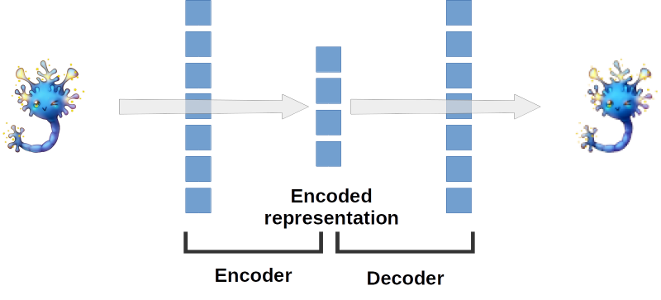

Each input presented to the autoencoder maps to a coordinate in the bottleneck layer that spans the lower-dimensional latent space.


Differences between inputs and outputs trigger the backpropagation of loss to adjust weights and better compress/decompress data. Autoencoders are examples of models that automatically build internal representations of the world and use them to predict unseen data.

**the images are vectorized i.e. stretched as a line**

In [3]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy().copy())

  return weights


def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def plot_weights_ab(encoder_w_a, encoder_w_b, decoder_w_a, decoder_w_b,
                    label_a='init', label_b='train',
                    bins_encoder=0.5, bins_decoder=1.5):
  """
  Plots row of histograms with encoder and decoder weights
  between two training checkpoints.

  Args:
    encoder_w_a (iterable)
        encoder weights at checkpoint a

    encoder_w_b (iterable)
        encoder weights at checkpoint b

    decoder_w_a (iterable)
        decoder weights at checkpoint a

    decoder_w_b (iterable)
        decoder weights at checkpoint b

    label_a (string)
        label for checkpoint a

    label_b (string)
        label for checkpoint b

    bins_encoder (float)
        norm of extreme values for encoder bins

    bins_decoder (float)
        norm of extreme values for decoder bins

  Returns:
    Nothing.
  """

  plt.figure(figsize=(fig_w * 1.2, fig_h * 1.2))

  # plot encoder weights
  bins = np.linspace(-bins_encoder, bins_encoder, num=32)

  plt.subplot(221)
  plt.title('Encoder weights to unit 0')
  plt.hist(encoder_w_a[0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(222)
  plt.title('Encoder weights to unit 1')
  plt.hist(encoder_w_a[1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(encoder_w_b[1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  # plot decoder weights
  bins = np.linspace(-bins_decoder, bins_decoder, num=32)

  plt.subplot(223)
  plt.title('Decoder weights from unit 0')
  plt.hist(decoder_w_a[:, 0].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 0].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.subplot(224)
  plt.title('Decoder weights from unit 1')
  plt.hist(decoder_w_a[:, 1].flatten(), bins=bins, alpha=0.3, label=label_a)
  plt.hist(decoder_w_b[:, 1].flatten(), bins=bins, alpha=0.3, label=label_b)
  plt.legend()

  plt.tight_layout()
  plt.show()


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

      plt.tight_layout()


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row
        number of rows in grid

  Returns:
    Nothing.
  """

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)
      with torch.no_grad():
          x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j + 1) * image_shape[0],
             i*image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    fontdict (dictionary)
        optional style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, title=None,
                           xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    title (string)
        plot title

    xy_labels (list)
        optional lsit with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500):
  """
  Two horizontal subplots with encoder maps.

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1) > show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  plt.figure(figsize=(12, 6))

  ax = plt.subplot(121)
  ax.set_title(title_a, y=1.05)
  plot_latent(x1, y, fontdict=fontdict)

  ax = plt.subplot(122)
  ax.set_title(title_b, y=1.05)
  plot_latent(x2, y, fontdict=fontdict)

  plt.tight_layout()


def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print final loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

In [4]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


shape x_train 		 torch.Size([60000, 28, 28])
shape x_test 		 torch.Size([10000, 28, 28])
shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


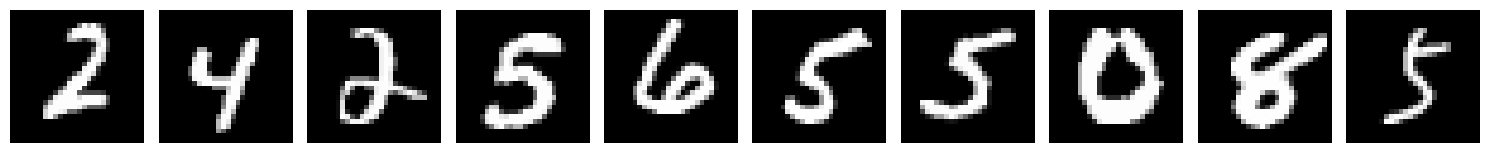

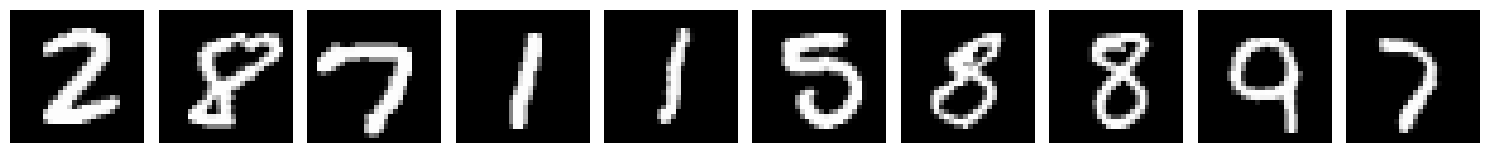

In [5]:
plot_row([x_test, x_test[test_selected_idx]])

## **Latent space visualization**

We'll introduce visualisation tools of latent space and apply them on Principal Component Analysis (PCA)

The plotting function plot_latent_generative helps visualize the encoding of inputs from high dimension into 2D latent space, and decoding back to the original dimension. This function produces two plots:

**Encoder map** shows the mapping from input images to coordinates (z1,z2)
 in latent space, with overlaid digit labels

**Decoder grid** shows reconstructions from a grid of latent space coordinates (z1,z2)

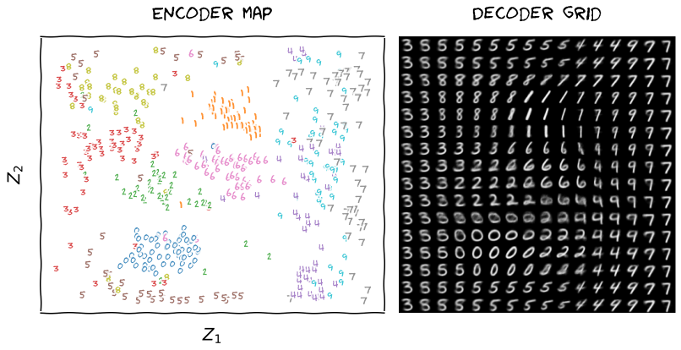

The latent space representation is a new coordinate system (z1,z2)
 that hopefully captures relevant structure from high-dimensional data. The coordinates of each input only matter relative to those of other inputs, i.e., we often care about separability between different classes of digits rather than their location.


The encoder map provides direct insight into the organization of latent space. Keep in mind that latent space only contains coordinates (z1,z2)
. We overlay additional information such as digit labels for insight into the latent space structure.

The plot on the left is the raw latent space representation corresponding to the plot on the right with digit labels overlaid.

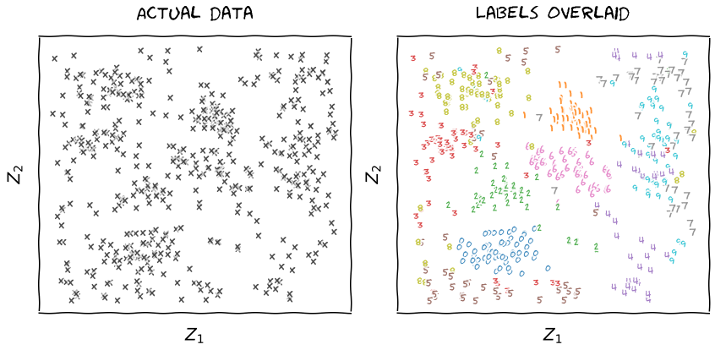

**Performing dimensionality reduction through PCA**

In [6]:
svd = decomposition.TruncatedSVD(n_components=2)

svd.fit(input_train)

svd_latent_train = svd.transform(input_train)
svd_latent_test = svd.transform(input_test)

svd_reconstruction_train = svd.inverse_transform(svd_latent_train)
svd_reconstruction_test = svd.inverse_transform(svd_latent_test)

In [9]:
help(plot_latent_generative)

Help on function plot_latent_generative in module __main__:

plot_latent_generative(x, y, decoder_fn, image_shape, title=None, xy_labels=None)
    Two horizontal subplots generated with encoder map and decoder grid.
    
    Args:
      x (list, numpy array or torch.Tensor of floats)
          2D coordinates in latent space
    
      y (list, numpy array or torch.Tensor of floats)
          digit class of each sample
    
      decoder_fn (integer)
          function returning vectorized images from 2D latent space coordinates
    
      image_shape (tuple or list)
          original shape of image
    
      title (string)
          plot title
    
      xy_labels (list)
          optional lsit with [xlabel, ylabel]
    
    Returns:
      Nothing.



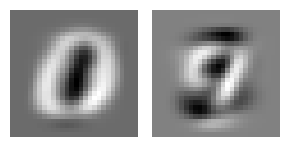

In [11]:
pca_components = pca.components_

plot_row(pca_components, image_shape=image_shape)

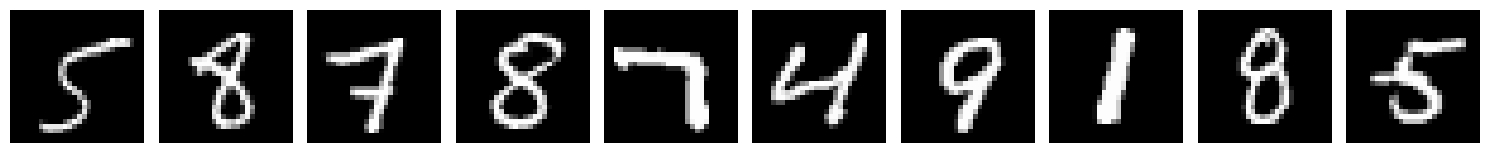

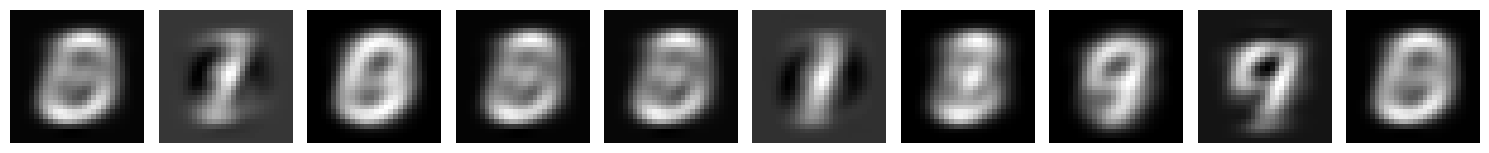

In [12]:
pca_output_test = pca.inverse_transform(pca_latent_test)

plot_row([input_test, pca_output_test], image_shape=image_shape)

## ANN autoencoder

Let's implement a shallow ANN autoencoder with a single hidden layer.

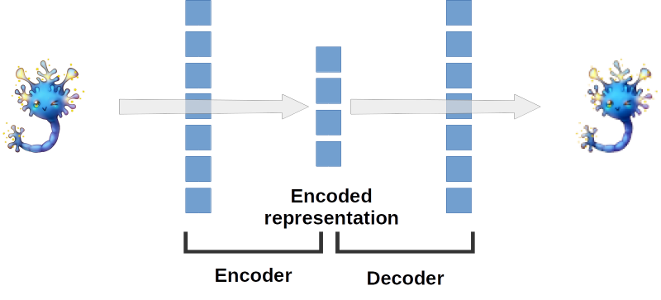!

In [13]:
encoding_size = 32

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    # insert your code here to add the layer
    nn.Linear(encoding_size, input_size),
    # insert the activation function
    nn.Sigmoid()
    )

print(f'Model structure \n\n {model}')

Model structure 

 Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=784, bias=True)
  (3): Sigmoid()
)


# Train autoencoders

Epoch 	 Loss train 	 Loss test
1 / 10	 0.0267		 0.0264
2 / 10	 0.0201		 0.0197
3 / 10	 0.0175		 0.0172
4 / 10	 0.0165		 0.0161
5 / 10	 0.0160		 0.0156
6 / 10	 0.0157		 0.0153
7 / 10	 0.0155		 0.0151
8 / 10	 0.0154		 0.0150
9 / 10	 0.0153		 0.0149
10 / 10	 0.0152		 0.0149


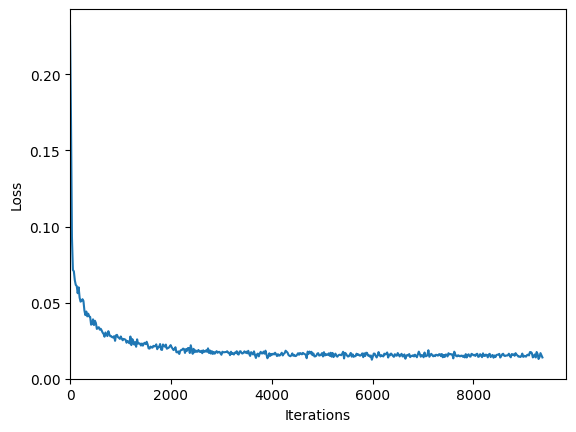

In [14]:
encoding_size = 32

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size)

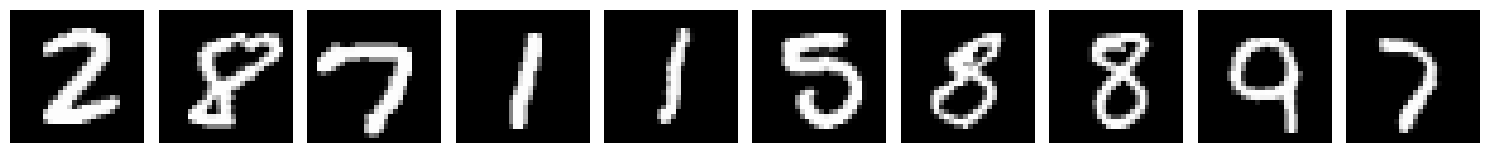

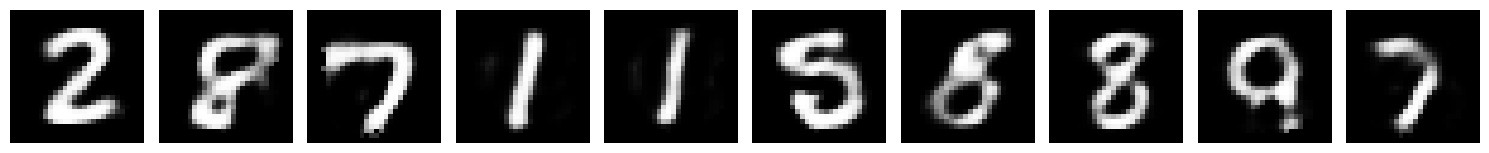

In [15]:
with torch.no_grad():
  output_test = model(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

In [16]:
encoding_size = 2

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.PReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

print(f'Autoencoder \n\n {model}')

Autoencoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)


In [17]:
print(f'Encoder \n\n {encoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=784, out_features=2, bias=True)
  (1): PReLU(num_parameters=1)
)


In [18]:
print(f'Decoder \n\n {decoder}')

Decoder 

 Sequential(
  (2): Linear(in_features=2, out_features=784, bias=True)
  (3): Sigmoid()
)


Epoch 	 Loss train 	 Loss test
1 / 10	 0.2633		 0.2629
2 / 10	 0.2575		 0.2572
3 / 10	 0.2524		 0.2523
4 / 10	 0.2466		 0.2464
5 / 10	 0.2406		 0.2404
6 / 10	 0.2357		 0.2354
7 / 10	 0.2328		 0.2323
8 / 10	 0.2311		 0.2306
9 / 10	 0.2298		 0.2294
10 / 10	 0.2290		 0.2284


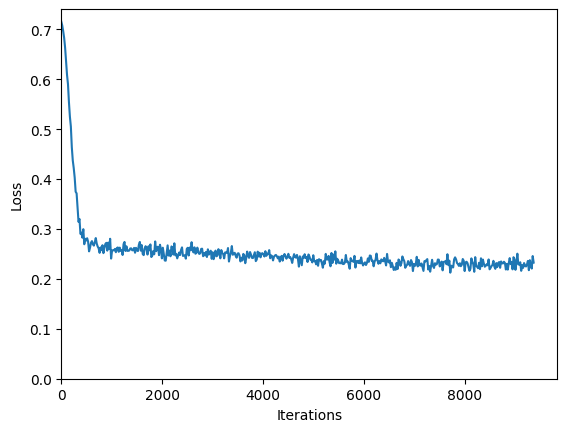

In [19]:
n_epochs = 10
batch_size = 64

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

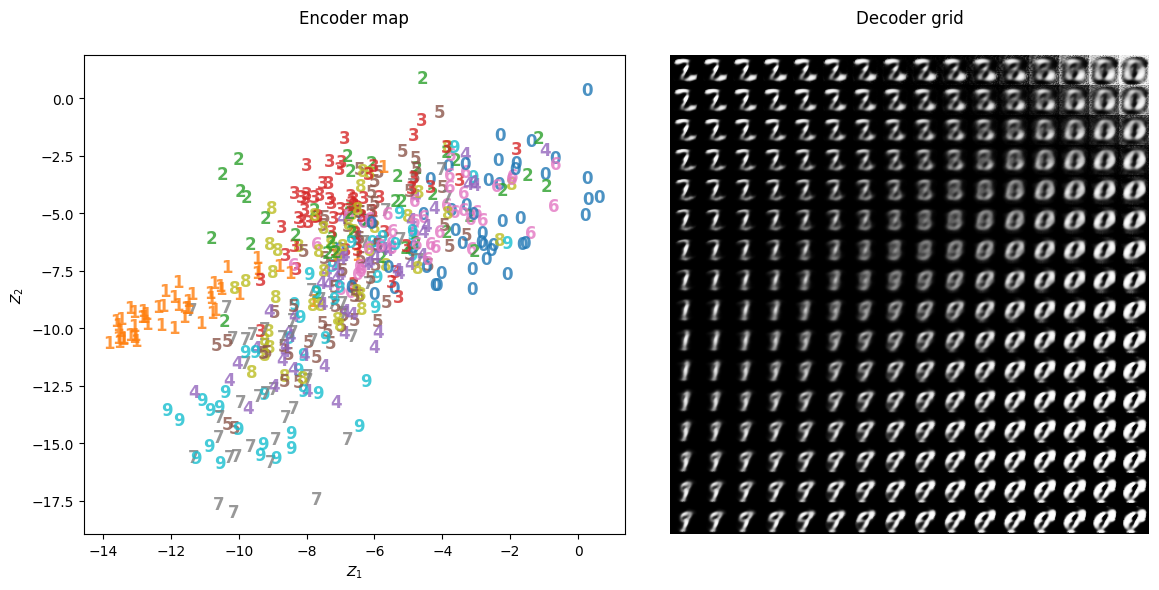

In [20]:
with torch.no_grad():
  latent_test = encoder(input_test)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape)

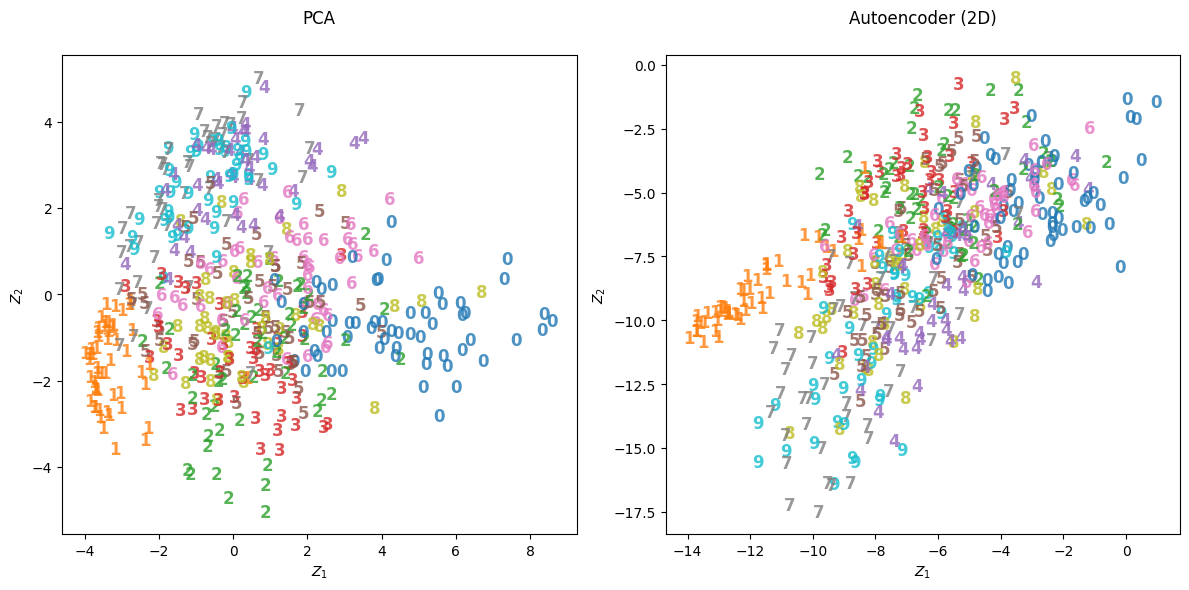

In [21]:
plot_latent_ab(pca_latent_test, latent_test, y_test,
               title_a='PCA', title_b='Autoencoder (2D)')

In [22]:
torch.manual_seed(0)
np.random.seed(0)

In [23]:
torch.manual_seed(1)

Epoch 	 Loss train 	 Loss test
1 / 10	 0.2654		 0.2651
2 / 10	 0.2600		 0.2598
3 / 10	 0.2573		 0.2572
4 / 10	 0.2554		 0.2552
5 / 10	 0.2539		 0.2538
6 / 10	 0.2524		 0.2523
7 / 10	 0.2509		 0.2508
8 / 10	 0.2493		 0.2491
9 / 10	 0.2476		 0.2474
10 / 10	 0.2460		 0.2458


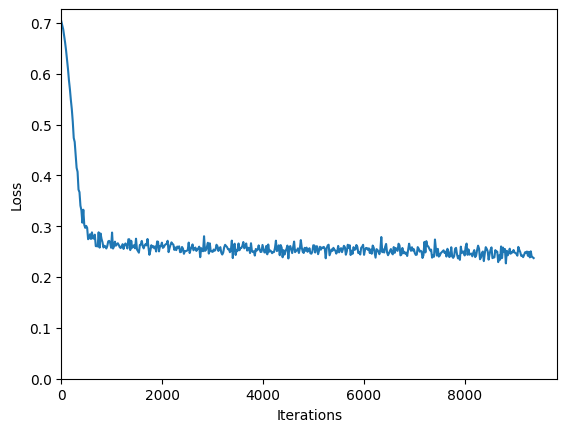

In [24]:
encoding_size = 2
n_epochs = 10
batch_size = 64

# set PyTorch RNG seed
torch_seed = 0

# reset RNG for weight initialization
torch.manual_seed(torch_seed)
np.random.seed(0)

model = nn.Sequential(
    nn.Linear(input_size, encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, input_size),
    nn.Sigmoid()
    )

encoder = model[:2]
decoder = model[2:]

# retrieve weights and biases from the encoder before training
encoder_w_init, encoder_b_init = get_layer_weights(encoder[0])
decoder_w_init, decoder_b_init = get_layer_weights(decoder[0])

# reset RNG for minibatch sequence
torch.manual_seed(torch_seed)
np.random.seed(0)

# train the autoencoder
runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

# retrieve weights and biases from the encoder after training
encoder_w_train, encoder_b_train = get_layer_weights(encoder[0])
decoder_w_train, decoder_b_train = get_layer_weights(decoder[0])

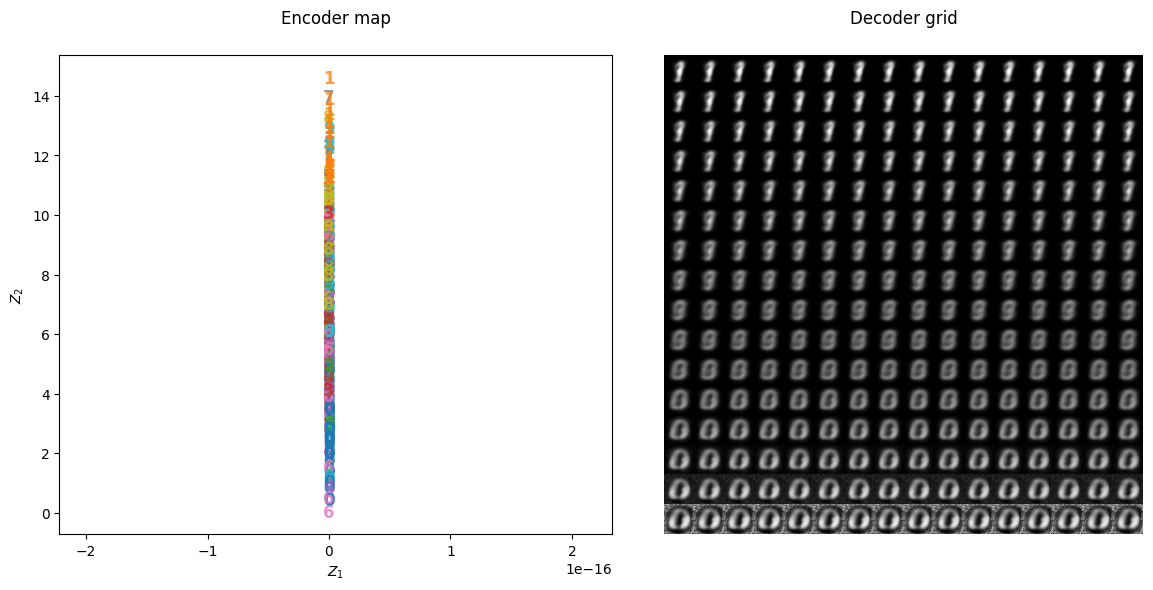

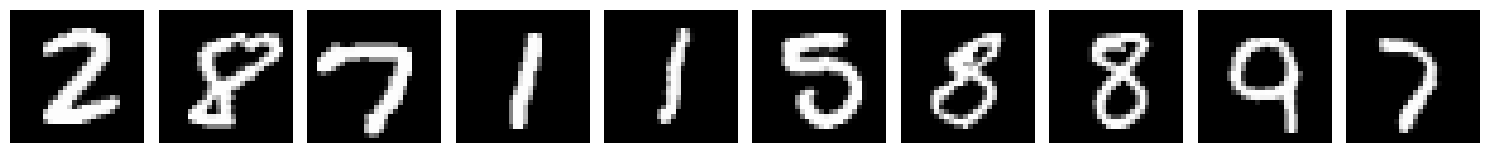

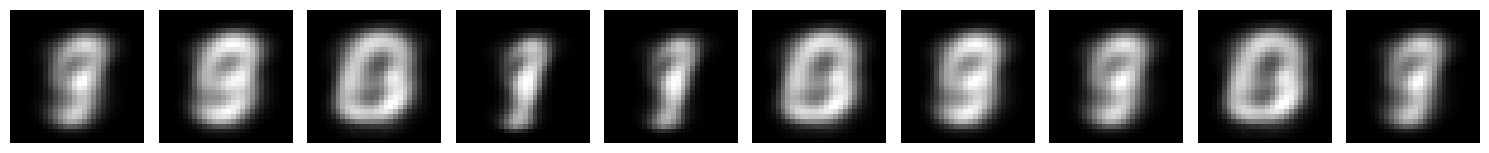

In [25]:
with torch.no_grad():
  latent_test = encoder(input_test)
  output_test = model(input_test)

plot_latent_generative(latent_test, y_test, decoder, image_shape=image_shape)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)